In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import numpy as np

## Create dummy dataset

#### Regresssion

In [2]:
SEED = 42

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [3]:
class SyntheticRegressionData:  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [4]:
d = 4

def get_weights(r1, r2, size):
    return (r1 - r2) * torch.rand(size) + r2


weight = get_weights(-3, 3, size=(d, ))

data = SyntheticRegressionData(w=weight, b=4.2)

### model Decleration

In [5]:
model = nn.Linear(d, 1)

#### training Loop

In [6]:
a = torch.zeros((0, d))

In [7]:
a = torch.cat([a, torch.rand(1, d)], axis = 0)
a

tensor([[0.9599, 0.5624, 0.5717, 0.8604]])

In [8]:
from tqdm.notebook import tqdm

def train_test_split(X, Y, test_size=0.2):
    train_x, train_y = torch.zeros((0, d)), torch.zeros((0, 1))
    test_x, test_y = torch.zeros((0, d)), torch.zeros((0, 1))
    
    for x, y in tqdm(zip(X, Y), total=len(X)):
        if np.random.uniform() > test_size:
            train_x = torch.cat([train_x, x.unsqueeze(0)], axis = 0)
            train_y = torch.cat([train_y, y.unsqueeze(0)], axis = 0)
        else:
            test_x = torch.cat([test_x, x.unsqueeze(0)], axis = 0)
            test_y = torch.cat([test_y, y.unsqueeze(0)], axis = 0)

    return train_x, train_y, test_x, test_y

In [9]:
train_x, train_y, test_x, test_y = train_test_split(data.X, data.y)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
print("Total :: ", len(data.X))
print()
print(f"Train dataset len :: {len(train_x)} prob :: {len(train_x)/ len(data.X)}")
print(f"Test dataset len :: {len(test_x)} prob :: {len(test_x)/ len(data.X)}")

assert len(train_x) == len(train_y)
assert len(test_x) == len(test_y)

Total ::  2000

Train dataset len :: 1572 prob :: 0.786
Test dataset len :: 428 prob :: 0.214


In [11]:
EPOCH = 6
BATCH_SIZE = 32
LEARNING_RATE = 0.01

cost_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)


def train_loop(epoch, train_x, train_y, batch_size=BATCH_SIZE):
    total_data_size = train_x.shape[0]
    running_loss = 0
    
    for i in tqdm(range(0, total_data_size, batch_size), total=total_data_size//batch_size):
        batch_x = train_x[i:i+batch_size]
        batch_y = train_y[i:i+batch_size]

            
        pred  = model(batch_x)
        loss = cost_function(pred, batch_y)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch :: {epoch} Average Loss :: {running_loss}")
    return running_loss


def validation_loop(epoch, test_x, test_y, batch_size=BATCH_SIZE):
    total_data_size = test_x.shape[0]
    running_loss = 0
    for i in tqdm(range(0, total_data_size, batch_size), total=total_data_size//batch_size):
        batch_x = test_x[i:i+batch_size]
        batch_y = test_y[i:i+batch_size]
        pred  = model(batch_x)
        loss = cost_function(pred, batch_y)
        running_loss += loss.item()

    return running_loss

In [12]:
def train(num_epoch=EPOCH):
    training_loss = []
    validation_loss = []
    for i in range(num_epoch):
        loss = train_loop(i+1, train_x, train_y)
        training_loss.append(loss)
        val_loss = validation_loop(i +1, test_x, test_y)
        validation_loss.append(val_loss)
    return training_loss, validation_loss

In [13]:
training_loss, validation_loss = train(EPOCH)

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :: 1 Average Loss :: 899.8960843086243


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :: 2 Average Loss :: 120.69374138116837


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :: 3 Average Loss :: 16.38790526241064


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :: 4 Average Loss :: 2.256075318902731


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :: 5 Average Loss :: 0.3182502264389768


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :: 6 Average Loss :: 0.049261942447628826


  0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
learned_weights = list(model.parameters())[0]

In [15]:
torch.testing.assert_close(learned_weights[0], weight, rtol=0.01, atol=0.01)

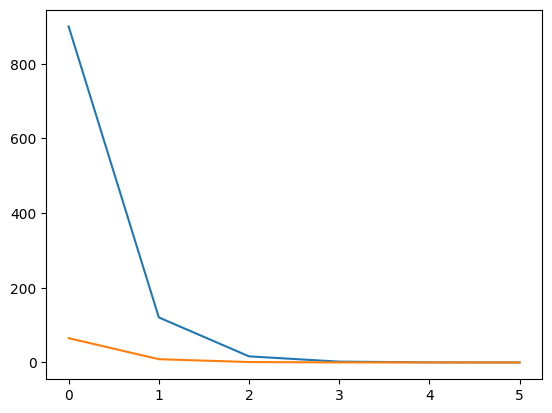

In [19]:
plt.plot(list(range(EPOCH)), training_loss)
plt.plot(list(range(EPOCH)), validation_loss)
plt.show()

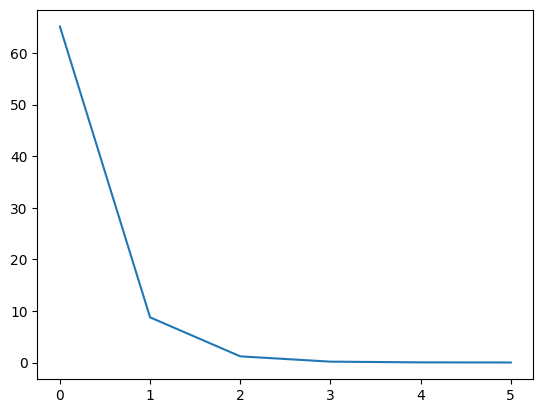